<a href="https://colab.research.google.com/github/Vicks-2019/TimeSeries/blob/main/Time_Series_Forecasting_LSTM_with_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [3]:

# load the data 
from google.colab import files
uploaded = files.upload()

Saving Beer_Production.csv to Beer_Production.csv


In [4]:

df = pd.read_csv('Beer_Production.csv')
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [6]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


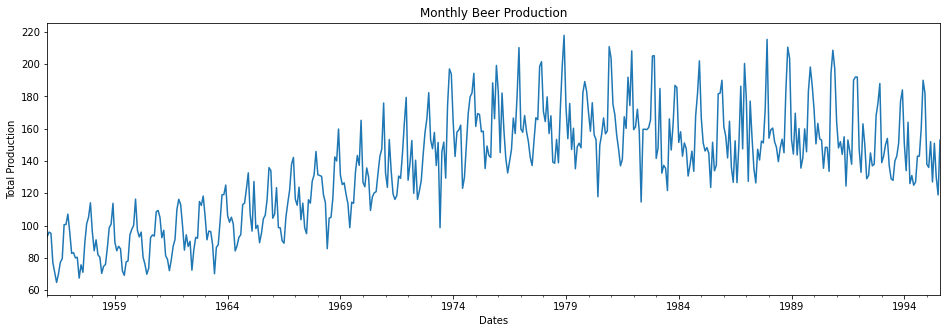

In [7]:
df.index.freq = 'MS'
ax = df['Monthly beer production'].plot(figsize = (16,5), title = "Monthly Beer Production")
ax.set(xlabel='Dates', ylabel='Total Production');

In [9]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [12]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
452/452 [==============================] - 6s 10ms/step - loss: 0.0439
Epoch 2/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0155
Epoch 3/20
452/452 [==============================] - 5s 10ms/step - loss: 0.0107
Epoch 4/20
452/452 [==============================] - 4s 10ms/step - loss: 0.0074
Epoch 5/20
452/452 [==============================] - 4s 10ms/step - loss: 0.0074
Epoch 6/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0078
Epoch 7/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0071
Epoch 8/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0072
Epoch 9/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0073
Epoch 10/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0071
Epoch 11/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0069
Epoch 12/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0056
Epoch 13/20
452/452 [

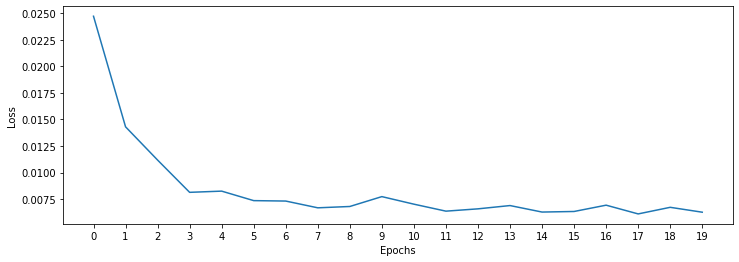

In [14]:
losses_lstm = lstm_model.history.history['loss']
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [15]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [16]:
lstm_predictions_scaled

[array([0.51968575], dtype=float32),
 array([0.6050363], dtype=float32),
 array([0.72076356], dtype=float32),
 array([0.71643794], dtype=float32),
 array([0.5505284], dtype=float32),
 array([0.5223652], dtype=float32),
 array([0.57627726], dtype=float32),
 array([0.42993027], dtype=float32),
 array([0.4287171], dtype=float32),
 array([0.4067352], dtype=float32),
 array([0.43127808], dtype=float32),
 array([0.49309254], dtype=float32)]

In [17]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[144.31191902],
       [157.3705567 ],
       [175.07682531],
       [174.41500418],
       [149.03084629],
       [144.7218775 ],
       [152.97042017],
       [130.57933127],
       [130.39371731],
       [127.03048738],
       [130.7855462 ],
       [140.24315815]])

In [18]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Monthly beer production,LSTM_Predictions
Month,,
1994-09-01,143.0,144.311919
1994-10-01,160.0,157.370557
1994-11-01,190.0,175.076825
1994-12-01,182.0,174.415004
1995-01-01,138.0,149.030846
1995-02-01,136.0,144.721878
1995-03-01,152.0,152.970420
1995-04-01,127.0,130.579331
1995-05-01,151.0,130.393717


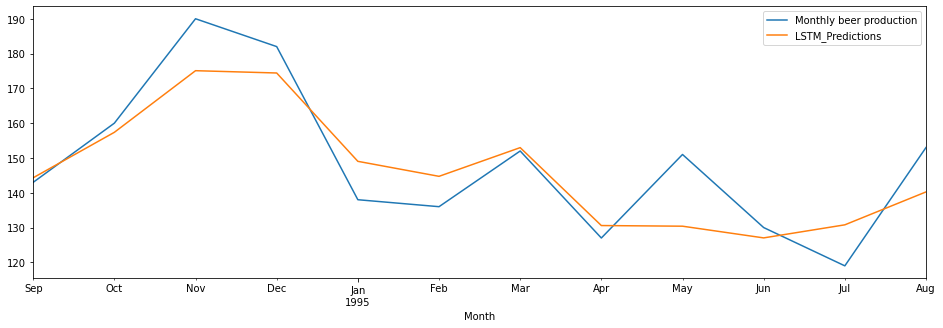

In [19]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [20]:
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 102.95378812601997
RMSE Error: 10.14661461404837
Mean: 136.39537815126045
